Project 4 - Advanced Lane Finding - Report. Vilas Chitrakaran. Mar 2017

## Executive Summary

The objective is to develop a computer vision pipeline to identify lane boundaries in a video stream obtained from a front-facing camera mounted on the dashboard of a car. Curvature of the road and the relative position of the car within the lane are identified in metric units. The following videos demonstrate the final result obtained from my implementation. 

* Video from the [front camera](https://youtu.be/XYvTyyFjJR4) showing the identified lane boundaries, the road curvature and vehicle lateral position within the lane.

* What's happening under the hood is shown in this [debugging video](https://youtu.be/zgabVNMf4I8), where the lane pixels are identified in the same video sequence that is perpective transformed to obtain a top view of the road.

The rest of this report describes how this was achieved.

Front Camera


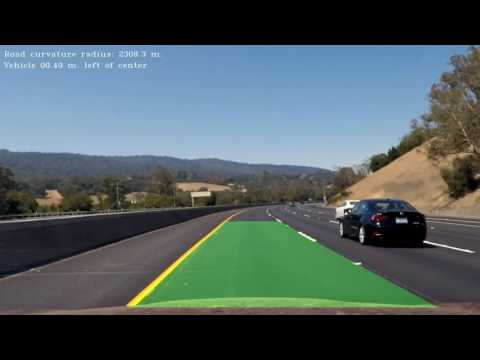

Debugging Video


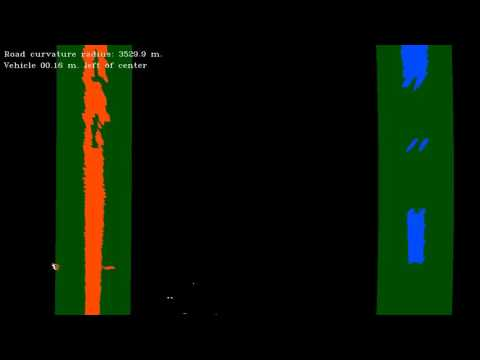

In [1]:
#=====================================================================
# Demo video of autonomous steering control using the network described in this report
import IPython
print('Front Camera')
vid = IPython.display.YouTubeVideo("XYvTyyFjJR4")
IPython.display.display(vid)
print('Debugging Video')
vid = IPython.display.YouTubeVideo("zgabVNMf4I8")
IPython.display.display(vid)

## Description of the Implementation

The vehicle is instrumented with a front-facing video camera that provides an RGB video stream of the road ahead. Ideally we'd like the top view or the bird's eye view in order to extract the lane, the curvature of the lane and the relative position of the vehicle on the lane. Much of the implementation focusses on how we obtain this bird's eye view and the image processing techniques that are then applied to identify pixels on the lane boundary.

### Camera Calibration

The first step is camera calibration. This is performed once, and we are specifically interested in the intrinsic calibration parameters and the distortion parameters that we will then use in the processing pipeline to correct for optical distortions in the image. Images of the calibration pattern (a checkerboard) were provided, and the following code implements the autonomous calibration procedure.   

In [2]:
#=====================================================================
# Camera calibration
# Note: The following comes from code provided in examples directory

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt5
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objPoints = [] # 3d points in real world space
imgPoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), cv2.CALIB_CB_ADAPTIVE_THRESH)

    # If found, add object points, image points
    if ret == True:
        objPoints.append(objp)
        imgPoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.figure()
        cv2.imshow('img',img)
        cv2.waitKey(500)
    else:
        print("Corner detection failed on ", fname)

cv2.destroyAllWindows()

# now calibrate the camera
ret, camMat, distParams, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
print('Camera intrinsic matrix:\n', camMat)
print('Camera distortion parameters:\n', distParams)



Corner detection failed on  ./camera_cal/calibration4.jpg
Corner detection failed on  ./camera_cal/calibration1.jpg
Corner detection failed on  ./camera_cal/calibration5.jpg
Camera intrinsic matrix:
 [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion parameters:
 [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


We now have the camera intrinsic parameters and the distortion coefficients. Let's check how good the parameters are by applying distortion correction to one of the calibration images.

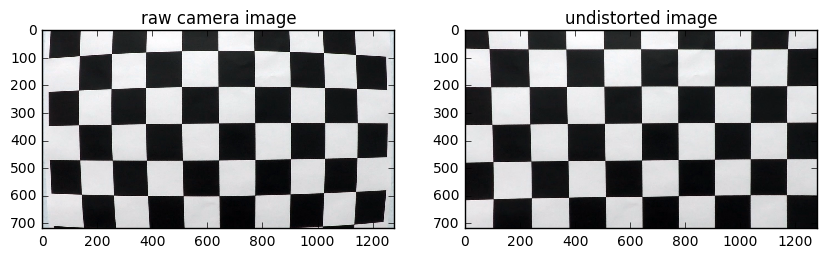

In [3]:
#=====================================================================
# Check calibration is good visually

img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, camMat, distParams, None, camMat)
cv2.imwrite('./output_images/01-undistorted_calibration_board.png', undist)

f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(img)
axarr[0].set_title('raw camera image')
axarr[1].imshow(undist)
axarr[1].set_title('undistorted image');


As seen on the image on the left above, the raw camera images have a significant radial distortion - the planar pattern appears like a pin-cushion. The image on the right is distortion corrected. Visually most lines appear straight and square. Notice that there is still some visible distortion in the edges (the square in the top left corner for instance). The process requires sufficient number of images with the calibration pattern appearing in different positions and orientations across the entire field of view of the camera. We used a total of 20 images, three images were discarded because the calibration procedure was unable to find the full checkerboard pattern in them. Never mind. We carry on with what we've got.

__Note__: The undistorted image is also saved in the `output_images` folder.

### Perspective Transform

We now have a means to obtain distortion-free images from the camera. The next step is to compute a perspective transformation matrix that can be applied on these distortion free front-view images to convert them to top-view.  By trial-and-error, we pick four points describing a trapezoid in the distortion-corrected 'source' image that are mapped to a rectangle in the 'destination' image such that the boundaries of a straight road in the source image appear parallel in the transformed destination image. To assist with this process, we were provided a couple of camera images of straight sections of the road in the `test_images` folder. I used one of the images, and experimented with the source points until the transformed images looked correct visually. The code below:

Points mapped from:
 [[  710.   470.]
 [ 1020.   700.]
 [  260.   700.]
 [  570.   470.]]
Points mapped to:
 [[ 1020.     0.]
 [ 1020.   720.]
 [  260.   720.]
 [  260.     0.]]
Perspective matrix:
 [[ -6.74382716e-01  -1.53086420e+00   1.07160494e+03]
 [ -7.66053887e-15  -2.11111111e+00   9.92222222e+02]
 [ -1.22514845e-17  -2.39197531e-03   1.00000000e+00]]
Inverse perspective matrix:
 [[ -1.48283753e+00   5.83720170e+00  -4.20278522e+03]
 [  2.54187804e-14   3.81301079e+00  -3.78335404e+03]
 [  4.26341341e-17   9.12062766e-03  -8.04968944e+00]]


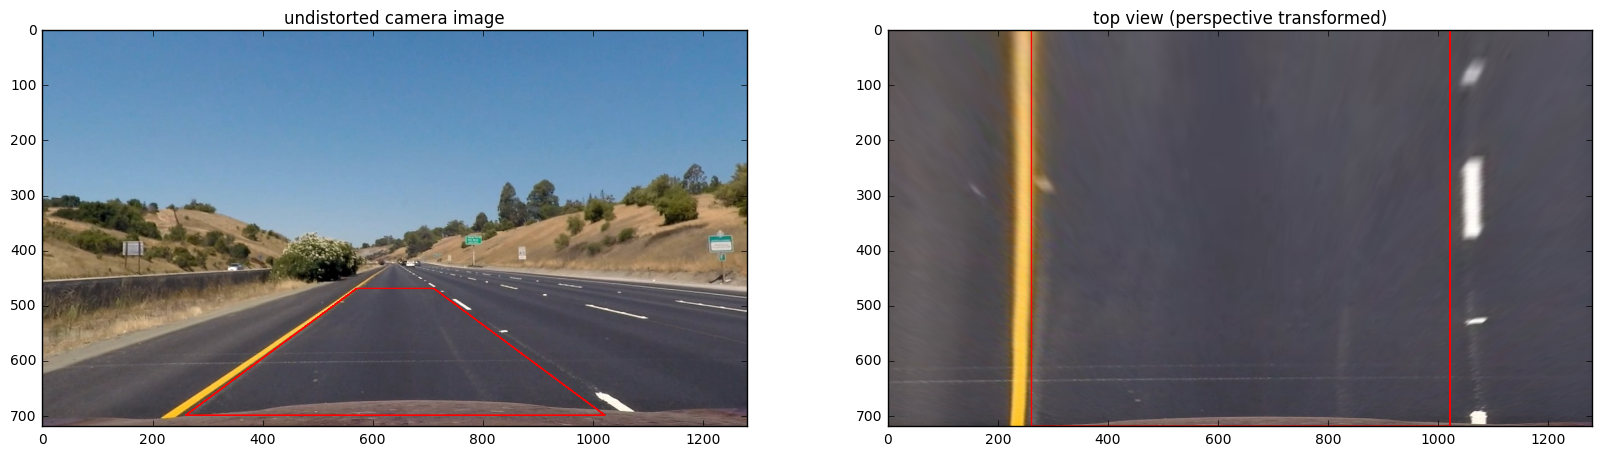

In [4]:
#=====================================================================
# Setup perspective transform

# generate perspective transform from src points defined as a trapeziod to
# dst defined as a rectangle
# xCenter - x-coord of vertical centerline
# xOffsetTop - x offset of left and right edges at the top
# xOffsetBottom - x offset of left and right edges at the bottom
# yTop - y-coord at the top
# yBottom - y-coord at the bottom
def setup_perspective(xCenter, xOffsetTop, xOffsetBottom, yTop, yBottom):
    
    # These points were selected from a given test image after applying undistortion
    image = cv2.imread('./test_images/straight_lines1.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(image, camMat, distParams, None, camMat)
    imgSz = (image.shape[1], image.shape[0])

    # source points
    imgSrcPts = np.float32(
        [[xCenter+xOffsetBottom,yBottom],
         [xCenter+xOffsetTop,yTop],
         [xCenter-xOffsetTop,yTop],
         [xCenter-xOffsetBottom,yBottom]])

    # destination points
    imgDstPts = np.float32(
        [[xCenter+xOffsetTop,0],
         [xCenter+xOffsetTop,image.shape[0]],
         [xCenter-xOffsetTop,image.shape[0]],
         [xCenter-xOffsetTop,0]])

    # generate the perspective matrix
    persMat = cv2.getPerspectiveTransform(imgSrcPts, imgDstPts)

    transformed = cv2.warpPerspective(undist, persMat, imgSz, flags=cv2.INTER_LINEAR)
    
    # draw src and dst guide lines on both images
    undist = cv2.polylines(undist, np.int32([imgSrcPts]), True, (255,0,0), 2)
    transformed = cv2.polylines(transformed, np.int32([imgDstPts]), True, (255,0,0), 2)
    
    # write images so I can inspect them visually
    cv2.imwrite('./output_images/02-top_view.png', cv2.cvtColor(transformed, cv2.COLOR_RGB2BGR))

    print('Points mapped from:\n', imgSrcPts)
    print('Points mapped to:\n', imgDstPts)

    f, axarr = plt.subplots(1,2,figsize=(20,10))
    axarr[0].imshow(undist)
    axarr[0].set_title('undistorted camera image')
    axarr[1].imshow(transformed)
    axarr[1].set_title('top view (perspective transformed)');
    f.savefig('./output_images/03-perspective_transformed.png')
    return persMat

# set the transformation source points interactively
#from IPython.html import widgets
#from IPython.html.widgets import interact
#from IPython.display import display

#persMat = interact(setup_perspective, 
#                    xCenter=(639,641), 
#                    xOffsetTop=(300,400),
#                    xOffsetBottom=(90,130), 
#                    yTop=(600,700), 
#                    yBottom=(450,550))

# Good starting point: xCenter=640, xOffsetTop=316, xOffsetBottom=110, yTop=650, yBottom=500
# Alt starting point: xCenter=640, xOffsetTop=380, xOffsetBottom=40, yTop=700, yBottom=450
persMat= setup_perspective(xCenter=640, xOffsetTop=380, xOffsetBottom=70, yTop=700, yBottom=470)

print('Perspective matrix:\n', persMat)
retval,invPersMat = cv2.invert(persMat)
if retval is 0:
    print('Cannot invert perspective matrix')
else:
    print('Inverse perspective matrix:\n', invPersMat)

Note that we also calculate the inverse of the projection matrix. This will be used later to project points in the top view back into the distorted corrected camera view.

__Note__: A sample top view image is saved in the `output_images` folder.

### Image to World Scaling

To obtain the road curvature and vehicle position in metric units, we will eventually need a scale factor that maps  all measurements in image coordinates (pixels) to real-world units. Since we now have a means to obtain the top view of the road, we can use some heuristics and public domain information to roughly estimate what these scale factors should be. [US roadway design regulations](http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC) require that the dashed lines are 10 feet or 3.05 meters long. In the perpective transformed top view image above, the dashed line was measured (using the Gimp 'measure tool') to be about 150 pixels long. Therefore,  

$metersPerPixelY  = \frac{3.05}{150} = 0.0203$ 

Similarly, the lanes must be at least 3.7 meters wide. In the transformed image above, they are 820 pixels center-to-center. Therefore, 

$metersPerPixelX = \frac{3.7}{820} = 0.0045$

__Note__: The 'metersPerPixelY' that I obtained does not quite match what is suggested in the lesson notes (which at $\frac{30}{720} = 0.0416$ differs by a factor of 2. Nevertheless, I stick with what I've got. In reality, we would want to accurately estimate the scale factors by actually measuring the metric dimensions of something in the real world and comparing it against its dimensions as visible in the image.

In [5]:
#=====================================================================
# Set the pixel-to-world scale factors

metersPerPixelY = 3.05/150
metersPerPixelX = 3.7/820

### Save Project Constants

Save all the one-time calculations into a dictionary so we can later reuse them in this project or another

In [7]:
#=====================================================================
# save constants

import pickle

pickleDict = {}
pickleDict["camMat"] = camMat
pickleDict["distParams"] = distParams
pickleDict["persMat"] = persMat
pickleDict["invPersMat"] = invPersMat
pickleDict["metersPerPixelY"] = metersPerPixelY
pickleDict["metersPerPixelX"] = metersPerPixelX

pickeFile = open("p4_camera_pickle.p", "wb")
pickle.dump(pickleDict, pickeFile)
pickeFile.close()


### Lane Search Algorithm
The lane search consists of a number of steps. First, the image is preprocessed to extract pixels on the lane markings and to eliminate extraneous details from the image. The image is then transformed to top view and one of two lane search algorithms is applied - a 'coarse search' algorithm that uses sliding windows to initialise the search when no prior lane information is available and a faster 'fine search' algorithm that is applied from frame-to-frame once we already know where the lanes are roughly. After the pixels belonging to lane boundary are extracted, we fit a second order polynomial to define the lane boundary and determine the lane curvature. the fitting process also enables us to obtain the lateral vehicle position within the lane. The estimated lane boundary is then back-projected and overlayed on the distortion-corrected camera image.

#### Image Thresholding
The lanes are bounded by solid yellow or white lines on the outer edges of the road and broken white lines in between. The yellow lines are best extracted by first converting the image from RGB to HSL colour space and then thresholding on the saturation channel. The white lines are best extracted by thresholding the gradient along the horizontal direction. We combine the two thresholded images into a binary image where the lane lines are always visible. The following method implements the thresholding.

In [8]:
#=====================================================================
# apply color and gradient threshold to extract lane pixels
def threshold(image, gradThreshMin=20, gradThreshMax=100, satThreshMin = 170, satThreshMax = 255):
    
    # For color threshold we need the s-channel from HLS space 
    # For gradient threshold we need grayscale image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    satChn = hls[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # find x gradient
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    absSobelX = np.absolute(sobelX) # Absolute x derivative to accentuate lines away from horizontal
    scaledSobel = np.uint8(255*absSobelX/np.max(absSobelX))
    
    # Threshold x gradient
    sxBinary = np.zeros_like(scaledSobel)
    sxBinary[(scaledSobel >= gradThreshMin) & (scaledSobel <= gradThreshMax)] = 1
    
    # Threshold color channel
    satBinary = np.zeros_like(satChn)
    satBinary[(satChn >= satThreshMin) & (satChn <= satThreshMax)] = 1
    
    # Combine the two binary thresholds
    combinedBinary = np.zeros_like(sxBinary)
    combinedBinary[(satBinary == 1) | (sxBinary == 1)] = 1
    
    return combinedBinary


#### Coarse Lane Search

When no prior information is available on where the lanes are in the image, we initialise the search at peaks of the histogram taken along all columns in the lower half of the image. The lane pixels are likely to be extracted clearly in this part of the image and we expect two peaks in the histogram. Once the peaks are identified, we apply a window around each peak to accumulate pixels that potentially fall on the left and right lane boundaries. We then continue the search for rest of the lane pixels by sliding the windows upwards and adjusting their lateral position as a function of pixel count within the window in order to follow the curvature of the lanes. The method implemented below returns coordinates of pixels that are identified as lying on the two lane markings.

__Note__: This basic approach to coarse lane finding works fine on the project video. Although not implemented here, there are a few improvements that I can think of that may improve the robustness of this algorithm, such as:
* Checking that the returned lane lines are separated by a certain number of pixels. If not, reinitialising the search again in the next frame
* Using region-of-interest and masking to reduce false positives

In [9]:
#=====================================================================
# Given a binary top-view image with lane pixels identified, return pixel coordinates list
# for left and right lanes and a debug image
# nWindows - number of sliding windows
# searchDx - horizontal search half width
# bDebug - set to True to create a debug image showing sliding windows and lane pixels
def coarse_lane_search(binaryTopView, nWindows=9, searchDx=100, bDebug=False):
    
    # Take a histogram of the bottom half of the image. Find peaks in the left and right halves.
    # Use them as starting point for left and right lane search 
    histogram = np.sum(binaryTopView[binaryTopView.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    xLeftBase = np.argmax(histogram[:midpoint])
    xRightBase = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonZero pixels in the image
    nonZero = binaryTopView.nonzero()
    nonZeroY = np.array(nonZero[0])
    nonZeroX = np.array(nonZero[1])
    
    # Current positions to be updated for each window
    xleftCurrent = xLeftBase
    xRightCurrent = xRightBase
    
    # Create empty lists to receive left and right lane pixel indices
    leftLaneInds = []
    rightLaneInds = []

    # create an image to show the sliding windows
    debugImage = None
    if bDebug:
        debugImage = np.dstack((binaryTopView, binaryTopView, binaryTopView))*255

    winHt = np.int(binaryTopView.shape[0]/nWindows)
    
    # Set minimum number of pixels found to recenter window
    minPix = (winHt * searchDx)/200

    # Step through the windows one by one
    for window in range(nWindows):
        
        # Identify window boundaries in x and y (and right and left)
        yLow = binaryTopView.shape[0] - (window+1)*winHt
        yHigh = binaryTopView.shape[0] - window*winHt
        xLeftLow = xleftCurrent - searchDx
        xLeftHigh = xleftCurrent + searchDx
        xRightLow = xRightCurrent - searchDx
        xRightHigh = xRightCurrent + searchDx
        
        # Identify the nonZero pixels in x and y within the window
        leftIndsGood = ((nonZeroY >= yLow) & (nonZeroY < yHigh) & (nonZeroX >= xLeftLow) \
                        & (nonZeroX < xLeftHigh)).nonzero()[0]
        rightIndsGood = ((nonZeroY >= yLow) & (nonZeroY < yHigh) & (nonZeroX >= xRightLow) \
                        & (nonZeroX < xRightHigh)).nonzero()[0]
        
        # Append these indices to the lists
        leftLaneInds.append(leftIndsGood)
        rightLaneInds.append(rightIndsGood)

        if bDebug:
            # Draw the windows on the visualization image
            cv2.rectangle(debugImage,(xLeftLow,yLow),(xLeftHigh,yHigh),(0,255,0), 2) 
            cv2.rectangle(debugImage,(xRightLow,yLow),(xRightHigh,yHigh),(0,255,0), 2) 
        
        # If you found > minPix pixels, recenter next window on their mean position
        if len(leftIndsGood) > minPix:
            xleftCurrent = np.int(np.mean(nonZeroX[leftIndsGood]))
        if len(rightIndsGood) > minPix:        
            xRightCurrent = np.int(np.mean(nonZeroX[rightIndsGood]))

    # Concatenate the arrays of indices
    leftLaneInds = np.concatenate(leftLaneInds)
    rightLaneInds = np.concatenate(rightLaneInds)

    # Extract left and right line pixel positions
    leftX = nonZeroX[leftLaneInds]
    leftY = nonZeroY[leftLaneInds] 
    rightX = nonZeroX[rightLaneInds]
    rightY = nonZeroY[rightLaneInds] 

    if bDebug:
        debugImage[leftY, leftX] = [255, 0, 0]
        debugImage[rightY, rightX] = [0, 0, 255]
    
    return leftX, leftY, rightX, rightY, debugImage


#### Curvature and Vehicle Offset

Given `x` and `y` coordinates of pixels that fall on the lane boundary, we fit a second order polynomial mapping $x = f(y)$ of the form

$x = Ay^2 + By + C$  

The radius of curvature $r_{curve}$ at any point $x$ on the above mapping is given by

$r_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^\frac{3}{2}}{|\frac{d^2x}{dy^2}|}$

where 

$\frac{dx}{dy} = 2Ay + B$

and

$\frac{d^2x}{dy^2} = 2A$

If we assume that the camera is mounted perfectly in the center of the dashboard, the difference between the location of the vertical centerline in the image and the midpoint of the extracted lane lines provide an estimate for how far the vehicle is off-center within the lane.

In [10]:
#=====================================================================
# Curvature and vehicle offset

# Return curvature evaluated at yEval given curve fit params
def get_curvature(leftFit, rightFit, yEval):
    leftRadius = ((1 + (2*leftFit[0]*yEval + leftFit[1])**2)**1.5) / np.absolute(2*leftFit[0])
    rightRadius = ((1 + (2*rightFit[0]*yEval + rightFit[1])**2)**1.5) / np.absolute(2*rightFit[0])
    return (leftRadius + rightRadius)/2

# Return vehicle offset from center. > 0 if vehicle is offset to the right of center
def get_offset_from_center(leftFit, rightFit, xMid, yEval):
    leftX = leftFit[0]*yEval**2 + leftFit[1]*yEval + leftFit[2]
    rightX = rightFit[0]*yEval**2 + rightFit[1]*yEval + rightFit[2]
    x = (leftX + rightX)/2
    return xMid - x

#### Fine Lane Search

Once we have a priori estimate of lane curve fit parameters, we can do a faster search on subsequent images by searching within a band about the curve. The following method implements this functionality.

In [11]:
#=====================================================================
# Given a previous set of lane fit parameters in pixel space, search in the neighbourhood 
# and return updated lane pixel vectors
def fine_lane_search(binaryTopView, leftFit, rightFit, searchDx=100, bDebug = False):
    
    debugImage = None
    if bDebug:
        debugImage = np.dstack((binaryTopView, binaryTopView, binaryTopView))*255
        
    # Identify the x and y positions of all nonZero pixels in the image
    nonZero = binaryTopView.nonzero()
    nonZeroY = np.array(nonZero[0])
    nonZeroX = np.array(nonZero[1])
    
    leftLaneInds = ((nonZeroX > (leftFit[0]*(nonZeroY**2) + leftFit[1]*nonZeroY + leftFit[2] - searchDx)) \
                    & (nonZeroX < (leftFit[0]*(nonZeroY**2) + leftFit[1]*nonZeroY + leftFit[2] + searchDx))) 
    rightLaneInds = ((nonZeroX > (rightFit[0]*(nonZeroY**2) + rightFit[1]*nonZeroY + rightFit[2] - searchDx)) \
                    & (nonZeroX < (rightFit[0]*(nonZeroY**2) + rightFit[1]*nonZeroY + rightFit[2] + searchDx)))  

    # Extract left and right line pixel positions
    leftX = nonZeroX[leftLaneInds]
    leftY = nonZeroY[leftLaneInds]
    rightX = nonZeroX[rightLaneInds]
    rightY = nonZeroY[rightLaneInds]
    
    # return with reinitialise flag set if we didnt find any pixels
    if leftX.size is 0 or rightX.size is 0:
        return True, leftX, leftY, rightX, rightY, debugImage   

    if bDebug:
        leftFit = np.polyfit(leftY, leftX, 2)
        rightFit = np.polyfit(rightY, rightX, 2)        
        plotY = np.linspace(0, binaryTopView.shape[0]-1, binaryTopView.shape[0] )
        leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
        rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]

        windowImg = np.zeros_like(debugImage)
        debugImage[leftY, leftX] = [255, 0, 0]
        debugImage[rightY, rightX] = [0, 0, 255]
        leftLineWindow1 = np.array([np.transpose(np.vstack([leftFitX-searchDx, plotY]))])
        leftLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitX+searchDx, plotY])))])
        leftLinePts = np.hstack((leftLineWindow1, leftLineWindow2))
        rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitX-searchDx, plotY]))])
        rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitX+searchDx, plotY])))])
        rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))
        
        cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
        cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
        debugImage = cv2.addWeighted(debugImage, 1, windowImg, 0.3, 0)

    return False, leftX, leftY, rightX, rightY, debugImage

#### Back-Projection

The lanes identified in the top view are back-projected into the original distortion corrected camera images by using the inverse of the projection matrix that we calculated earlier on.

In [12]:
#=====================================================================
# Take the lane curvature parameters and back project the detected lane 
# on to undistorted image
def back_project(binaryTopView, leftFit, rightFit, invPersMat):
    plotY = np.linspace(0, binaryTopView.shape[0]-1, binaryTopView.shape[0] )
    leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
    rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]

    # Create an image to draw the lines on
    colorWarped = np.dstack((binaryTopView, binaryTopView, binaryTopView))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ptsLeft = np.array([np.transpose(np.vstack([leftFitX, plotY]))])
    ptsRight = np.array([np.flipud(np.transpose(np.vstack([rightFitX, plotY])))])
    pts = np.hstack((ptsLeft, ptsRight))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorWarped, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    return cv2.warpPerspective(colorWarped, invPersMat, (binaryTopView.shape[1], binaryTopView.shape[0])) 

#### Test 

We have all the individual image processing methods in place. The following code blocks test whether these methods work as expected. First, a few utility functions that will come handy when we put the pipeline together.

In [13]:
#=====================================================================
# utility functions

# read in image as RGB
def read_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# apply distortion correction to the image
def undistort(image, camMat, distParams):
    return cv2.undistort(image, camMat, distParams, None, camMat)

# apply perspective transform to generate top view
def generate_top_view(image, persMat):
    imgSz = (image.shape[1], image.shape[0])
    transformed = cv2.warpPerspective(image, persMat, imgSz, flags=cv2.INTER_LINEAR)
    return transformed


Here is a sequence of tests for the methods defined so far.

__Note__: Images generated by the following code are in the `output_images` folder.

/home/vilas/programs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Road curvature radius:  3222.04912417 m.
Vehicle offset from center: -0.0879366045082 m.


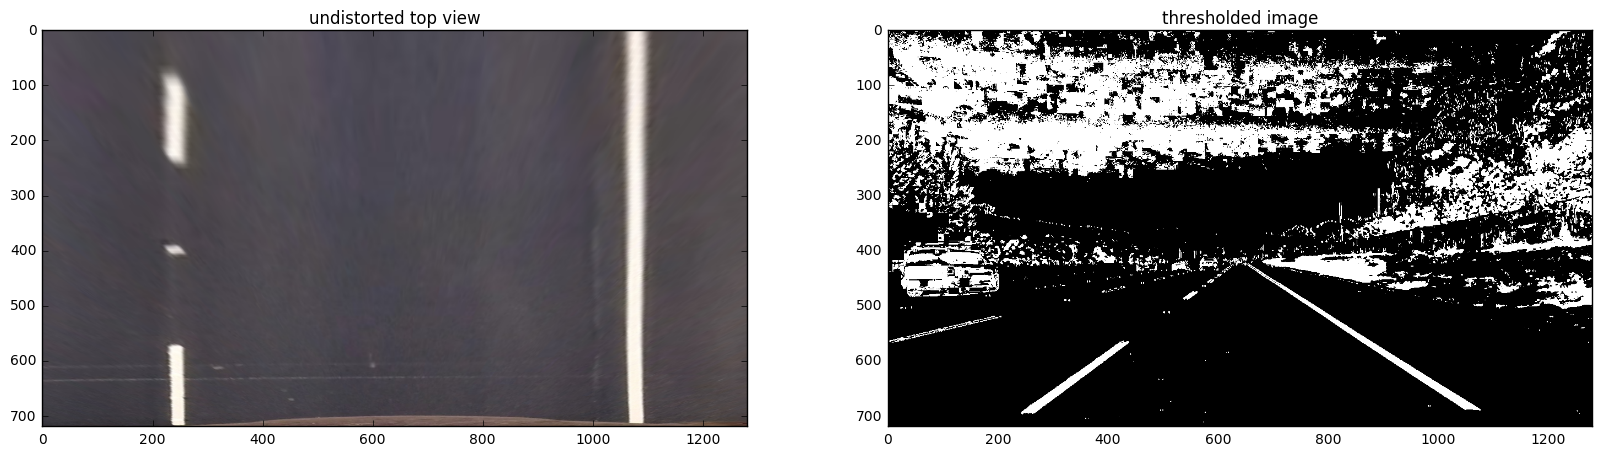

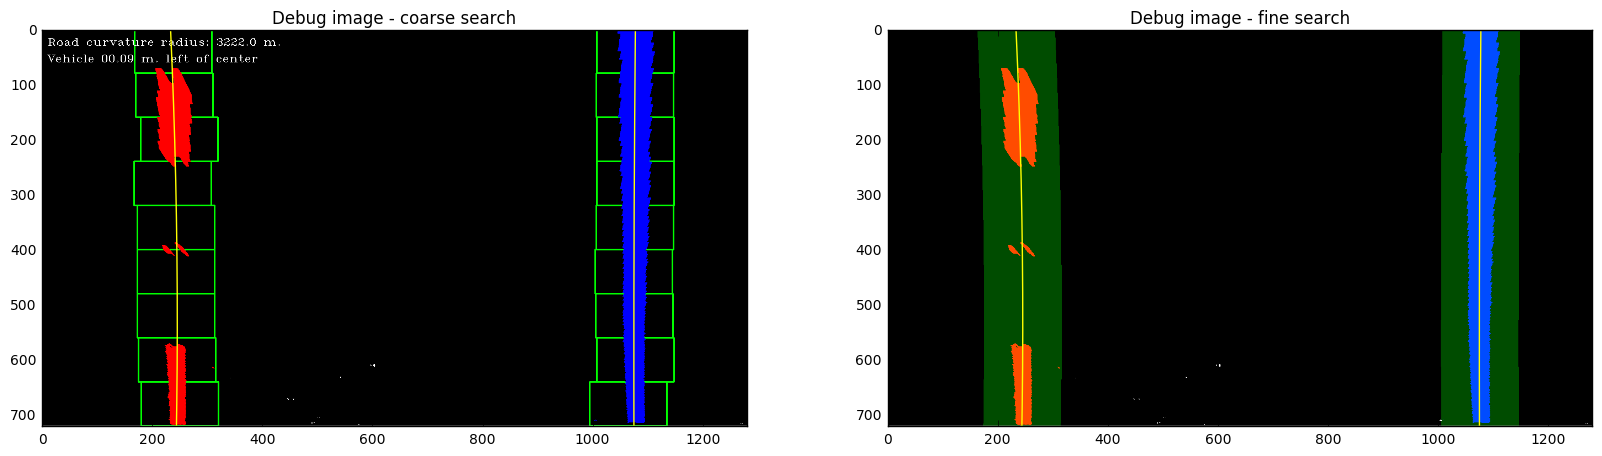

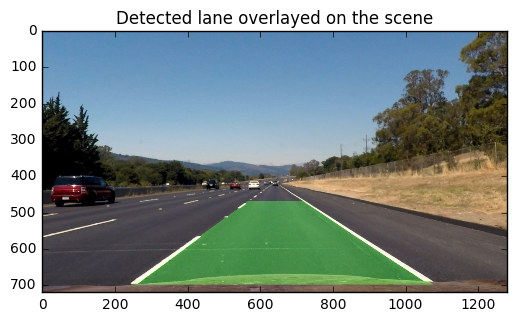

In [14]:
#=====================================================================
# Test individual functions

# Read an image, transform to top view and threshold
image = read_image('./test_images/straight_lines2.jpg')

undistorted = undistort(image, camMat, distParams)

top_view = generate_top_view(undistorted, persMat)

thresholded = threshold(undistorted, gradThreshMin=30, gradThreshMax=255, 
                        satThreshMin = 100, satThreshMax = 255)

binaryTopView = generate_top_view(thresholded, persMat)

# We want to generate debug images
bDebug = True

# Test coarse lane finding
leftX, leftY, rightX, rightY, debugImage = coarse_lane_search(binaryTopView,
                                                    nWindows=9, 
                                                    searchDx=70,
                                                    bDebug=bDebug)

# Fit a second order polynomial to lane pixels (coarse)
leftFit = np.polyfit(leftY, leftX, 2)
rightFit = np.polyfit(rightY, rightX, 2)

# Test fine lane finding
found,leftX, leftY, rightX, rightY, debugImage2 = fine_lane_search(binaryTopView, 
                                                       leftFit, rightFit, 
                                                       searchDx=70, 
                                                       bDebug = bDebug)

# Fit a second order polynomial to lane pixels (fine)
leftFit2 = np.polyfit(leftY, leftX, 2)
rightFit2 = np.polyfit(rightY, rightX, 2)

# Fit a second order polynomial to lane pixels after scaling to real world units (meters)
leftFit_m = np.polyfit(leftY*metersPerPixelY, leftX*metersPerPixelX, 2)
rightFit_m = np.polyfit(rightY*metersPerPixelY, rightX*metersPerPixelX, 2)

# compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binaryTopView.shape[0]*metersPerPixelY)
offset = get_offset_from_center(leftFit, rightFit, binaryTopView.shape[1]/2, binaryTopView.shape[0])
print('Road curvature radius: ', radius, 'm.')
print('Vehicle offset from center:', offset*metersPerPixelX, 'm.')

# add measurements to the debug image
text = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(debugImage, text, (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 

if offset < 0:
    lr = "left"
else:
    lr = "right"
text = "Vehicle %05.2f m. %s of center" % (np.fabs(offset)*metersPerPixelX, lr)
cv2.putText(debugImage, text, (10,60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 
cv2.imwrite('./output_images/04-debug_sliding_windows.png', cv2.cvtColor(debugImage, cv2.COLOR_RGB2BGR))

# now plot some figures
f, axarr = plt.subplots(1,2,figsize=(20,10))
axarr[0].imshow(top_view)
axarr[0].set_title('undistorted top view')
axarr[1].imshow(thresholded,cmap='gray')
axarr[1].set_title('thresholded image');

if bDebug is True:
    f, axarr = plt.subplots(1,2,figsize=(20,10))
    plotY = np.linspace(0, binaryTopView.shape[0]-1, binaryTopView.shape[0] )
    leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
    rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]
    axarr[0].imshow(debugImage)
    axarr[0].plot(leftFitX, plotY, color='yellow')
    axarr[0].plot(rightFitX, plotY, color='yellow')
    axarr[0].set_xlim(0, binaryTopView.shape[1])
    axarr[0].set_ylim(binaryTopView.shape[0], 0)
    axarr[0].set_title('Debug image - coarse search')

    leftFitX2 = leftFit2[0]*plotY**2 + leftFit2[1]*plotY + leftFit2[2]
    rightFitX2 = rightFit2[0]*plotY**2 + rightFit2[1]*plotY + rightFit2[2]
    axarr[1].imshow(debugImage2)
    axarr[1].plot(leftFitX2, plotY, color='yellow')
    axarr[1].plot(rightFitX2, plotY, color='yellow')
    axarr[1].set_xlim(0, binaryTopView.shape[1])
    axarr[1].set_ylim(binaryTopView.shape[0], 0)
    axarr[1].set_title('Debug image - fine search')
    f.savefig('./output_images/05-debug_lane_search.png')

# back-project the extracted lane into the original distortion-corrected image 
overlay = back_project(binaryTopView, leftFit, rightFit, invPersMat)
overlayedScene = cv2.addWeighted(undistorted, 1, overlay, 0.3, 0)
plt.figure()
plt.imshow(overlayedScene)
plt.title('Detected lane overlayed on the scene')
plt.savefig('./output_images/06-debug_lane_overlayed.png')


### The Processing Pipeline

We have all the individual elements to put together an image processing pipeline for the video stream obtained from the dash mounted camera. The following steps are applied in sequence:

* Apply distortion correction
* Threshold
* Generate top view
* Search for lane pixels
  * On the first image initialise lane search using coarse lane search algorithm
  * For every subsequent image update lane search using fine lane search algorithm
* Compute polynomial fit on lane pixels
* Apply temporal smoothing on the polynomial fit parameters
* Compute lane curvature and vehicle position
* Overlay information on distortion corrected image
* Go to first step

The temporal smoothing of polynomial fit parameters between image frames ensures that the pipeline doesn't fall over due to failure on a single image in the video stream. I use a simple low-pass filter here.

In [18]:
#=====================================================================
# The processing pipeline

class LaneDetector:
    
    def __init__(self):
        self._initSearch = True
        self._leftFit = np.array([0, 0, 0])
        self._rightFit = np.array([0, 0, 0])
        self._debugFlag = False

        # Load camera calibration, perpective projection and scaling parameters
        # that were saved from project 4 (lane detection)
        pickleDict = pickle.load( open("p4_camera_pickle.p", "rb" ) )
        self._camMat = pickleDict["camMat"]
        self._distParams = pickleDict["distParams"]
        self._persMat = pickleDict["persMat"]
        self._invPersMat = pickleDict["invPersMat"]
        self._metersPerPixelY = pickleDict["metersPerPixelY"]
        self._metersPerPixelX = pickleDict["metersPerPixelX"]

    def set_debug(self,bFlag):
        self._debugFlag = bFlag

    def process_image(self,image):
        # NOTE: The output you return should be a color image (3 channel) for processing video below
        
        # apply distortion correction, find lane pixels and transform to top view
        undistorted = undistort(image, self._camMat, self._distParams)
        thresholded = threshold(undistorted, gradThreshMin=30, gradThreshMax=255, 
                                satThreshMin = 100, satThreshMax = 255)
        binary_plan = generate_top_view(thresholded, self._persMat)
        
        # if this is the first frame or if we lost lanes, re-initialise with a coarse search for lanes
        if self._initSearch is True:
            leftX, leftY, rightX, rightY, debugImage = coarse_lane_search(binary_plan, nWindows=9,
                                                                          searchDx=70, 
                                                                          bDebug=self._debugFlag)
            self._initSearch = False
            self._leftFit = np.polyfit(leftY, leftX, 2)
            self._rightFit = np.polyfit(rightY, rightX, 2)
            
        # already know roughly where lanes are. do fine search
        else:
            self._initSearch, leftX, leftY, rightX, rightY, debugImage = fine_lane_search(binary_plan,
                                                                                          self._leftFit,
                                                                                          self._rightFit,
                                                                                          bDebug=self._debugFlag)
        
        # if search succeeded, update curvature parameters
        curvatureInfo = "Road curvature radius: unknown"
        vehiclePosInfo = "Vehicle position unknown"
        if self._initSearch is False:
            leftFit = np.polyfit(leftY, leftX, 2)
            rightFit = np.polyfit(rightY, rightX, 2)
            
            # apply temporal smoothing with exponential filter
            alpha = 0.8
            self._leftFit = self._leftFit * alpha + leftFit * (1 - alpha)
            self._rightFit = self._rightFit * alpha + rightFit * (1 - alpha)
            
            # Fit a second order polynomial to lane pixels after scaling to real world units (meters)
            leftFit_m = np.polyfit(leftY*self._metersPerPixelY, leftX*self._metersPerPixelX, 2)
            rightFit_m = np.polyfit(rightY*self._metersPerPixelY, rightX*self._metersPerPixelX, 2)
            
            # Find the radius of curvature and vehicle offset from lane center
            radius = get_curvature(leftFit_m, rightFit_m, binary_plan.shape[0]*self._metersPerPixelY)
            offset = get_offset_from_center(leftFit, rightFit, binary_plan.shape[1]/2, binary_plan.shape[0])
            
            curvatureInfo = "Road curvature radius: %05.1f m." % (radius)
            
            if offset < 0:
                lr = "left"
            else:
                lr = "right"
            vehiclePosInfo = "Vehicle %05.2f m. %s of center" % (np.fabs(offset)*self._metersPerPixelX, lr)

        
        # overlay lane and vehicle information on output image
        if self._debugFlag is True:
            cv2.putText(debugImage, curvatureInfo, (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 
            cv2.putText(debugImage, vehiclePosInfo, (10,60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 
            return debugImage
        else:
            overlay = back_project(binary_plan, self._leftFit, self._rightFit, self._invPersMat)
            resultImage = cv2.addWeighted(undistorted, 1, overlay, 0.3, 0)
            cv2.putText(resultImage, curvatureInfo, (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 
            cv2.putText(resultImage, vehiclePosInfo, (10,60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, [255,255,255], 1) 
            return resultImage

## Processing the Project Video

All that remains now is to process the video sequence by applying the processing pipeline described in the previous section.

In [19]:
#=====================================================================
# process the project video

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bDebug = False

# set inputs and putputs
input_video = VideoFileClip("project_video.mp4")
if bDebug is True:
    output_video_name = 'output_debug.mp4'
else:
    output_video_name = 'output.mp4'

# setup the processor
processor = LaneDetector()
processor.set_debug(bDebug)
process_image = processor.process_image

# process the input video
output_video = input_video.fl_image(process_image)
%time output_video.write_videofile(output_video_name, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:00<00:00,  5.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 25min 31s, sys: 45.5 s, total: 26min 16s
Wall time: 4min 2s


![sample frame from output](output_images/07-screenshot_from_output.mp4.png "Sample frame from output")

Here's the video from the [front camera](https://youtu.be/XYvTyyFjJR4) showing the identified lane boundaries, the road curvature and vehicle lateral position within the lane.

If the `global_debug_flag` is set to `True`, the above code generates a debug video that shows what's happening under the hood, as shown in this [debugging video](https://youtu.be/zgabVNMf4I8).


## Conclusions

This report described a processing pipeline to extract lane lines, their curvature and position of the vehicle within the lane. I have a newfound appreciation for the end-to-end deep learning approach implemented in Project 3, given how many parameters there are to tune in this particular project. As noted in the section on image-to-world scaling, the scale factors I used seem to generate road curvature estimates that are different from what the lesson notes seem to suggest. However, given that there is a rationale behind my scale factor estimates, I decided to stick with them. In reality this could be easily corrected by a few additional ground-truth observations.